---
title : "Overstromingsrisico scenarios"
execute:
    output: asis
---

Scenarios worden gebruikt om de mogelijke gevolgen van overstromingen in kaart te brengen. <br>
Hiermee kan de kans uit een fragilitycruve gecombineerd worden met de gevolgen die bepaald zijn bij een scenario om zo een beter inzicht te krijgen in het totale risico. <br>
Dit kan helpen om prioriteiten te stellen op basis van een totaal beeld en niet alleen op basis van kans of gevolg afzonderlijk. <br>
Om de scenarios te kunnen combineren moeten er een aantal stappen worden doorlopen:
- Omrekenen van dijkvakkansen naar trajectdeelkansen ([CalculateFloodScenarioProbability](#sec-CalculateFloodScenarioProbability))
- Belasting per deeltraject bepalen ([LoadFromFloodScenarioProbabilit](#sec-LoadFromFloodScenarioProbabilit))
- Met de belasting een bijpassende overstromingscenario selecteren ([SelectFloodScenarioFromLoad ](#sec-SelectFloodScenarioFromLoad))
- Van het scenario en de curve een geagregeerd risico bepalen ([CalculateFloodRisk](#sec-CalculateFloodRisk))


In [1]:
from pathlib import Path

from toolbox_continu_inzicht.base.config import Config
from toolbox_continu_inzicht.base.data_adapter import DataAdapter

In [2]:
path = Path.cwd() / "data_sets" / "7.flood_scenarios"
config = Config(config_path=path / "test_calculate_flood_scenario_probability.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

In [3]:
from toolbox_continu_inzicht.flood_scenarios import CalculateFloodScenarioProbability

## CalculateFloodScenarioProbability{sec-CalculateFloodScenarioProbability}

Dit voorbeeld laat zien hoe met behulp van de `CalculateFloodScenarioProbability`  dijkvakkansen naar trajectdeelkansen kunnen worden omgezet. <br>
Hiervoor is de **gecombineerde** faalkans per dijkvak nodig en een mapping van dijkvakken naar dijktraject delen van daar naar de overstromingsscenario gebieden.


>|⚠️ **Nog checken**|
>|---|
>- of we eerst alle mechanismes combineren, en dan naar dijktraject delen combineren (doen we nu). 
>- of eerst naar dijktraject delen combineren en dan de mechanismes combineren.

```yaml|
GlobalVariables:
    rootdir: "data_sets/7.flood_scenarios"
    moments: [-24,0,24,48]

DataAdapter:
    default_options:
        csv:
            sep: ","
    combined_failure_probability_data:
        type: csv
        file: "combined_failure_probability_data.csv"
    section_id_to_segment_id:
        type: csv
        file: "section_id_to_segment_id.csv"
    segment_failure_probability:
        type: csv
        file: "segment_failure_probability.csv"
```

In [4]:
calculate_flood_scenario_probability = CalculateFloodScenarioProbability(
    data_adapter=data_adapter
)
calculate_flood_scenario_probability.run(
    input=["combined_failure_probability_data", "section_id_to_segment_id"],
    output=["segment_failure_probability", "gecombineerde_faalkans_dijkvakken"],
)

In [5]:
calculate_flood_scenario_probability.df_in_sections_to_segment

,section_id,segment_id,length
0,1,34003,2
1,3,34003,3
2,4,34003,1
3,5,34002,1
4,6,34002,1
5,7,34002,1
6,8,34002,1
7,9,34002,1
8,15,34002,2
9,16,34002,3


In [6]:
df = calculate_flood_scenario_probability.df_in_grouped_sections_failure_probability

In [7]:
df["section_id"][df["section_id"] < 1.5].min()

np.int64(1)

In [8]:
calculate_flood_scenario_probability.df_out

,segment_id,failure_probability
0,34003,0.183333
1,34002,0.000526


In [9]:
# across all dike sections, needed for CalculateFloodRisk
calculate_flood_scenario_probability.df_out_combined_failure

,combined_failure_probability
0,0.044382


## LoadFromFloodScenarioProbability{sec-LoadFromFloodScenarioProbabilit}

Nu we de faalkansen per trajectdeel hebben kunnen we met de `LoadFromFloodScenarioProbability` de belasting per trajectdeel bepalen. <br>
Dit doen we om een bijpassende overstromingsscenario te kunnen selecteren. <br>
Met de input van de vorige stap `segment_failure_probability`, maken we een koppeling naar de bijhorende bres en fragilitycurve die representatief is voor een deeltraject met de tabel `breach_id_to_segment_id`. <br>
Deze `representative_section_id_fragilitycurve` kan vervolgens uit de data van de curves in `section_failure_probability_data` worden gehaald. <br>
Met de curve wordt de hydraulische belasting bepaald voor het deeltraject.

```yaml
GlobalVariables:
    rootdir: "data_sets/7.flood_scenarios"
    moments: [ -24, 0, 24, 48 ]

DataAdapter:
    default_options:
        csv:
            sep: ","
    segment_failure_probability:
        type: csv
        file: "segment_failure_probability.csv"
    breach_id_to_segment_id:
        type: csv
        file: "breach_id_to_segment_id.csv"
    section_failure_probability_data:
        type: csv
        file: "fragility_curve_multi_section.csv"
    flood_scenario_load_resultaten:
        type: csv
        path: "hidden_flood_scenario_load_resultaten.csv"

```

In [10]:
config = Config(config_path=path / "test_load_from_flood_scenario_probability.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

In [11]:
data_adapter.input("segment_failure_probability")

,Unnamed: 0,segment_id,failure_probability
0,0,34003,0.183333
1,1,34002,0.000526


In [12]:
data_adapter.input("breach_id_to_segment_id")

,segment_id,breach_id,representative_section_id_fragilitycurve
0,34003,1,1
1,34002,11,9


In [13]:
df = data_adapter.input("section_failure_probability_data")

In [14]:
from toolbox_continu_inzicht.flood_scenarios import LoadFromFloodScenarioProbability

In [15]:
load_from_flood_scenario_probability = LoadFromFloodScenarioProbability(
    data_adapter=data_adapter
)
load_from_flood_scenario_probability.run(
    input=[
        "segment_failure_probability",
        "breach_id_to_segment_id",
        "section_failure_probability_data",
    ],
    output="flood_scenario_load_resultaten",
)

In [16]:
data_adapter.input("flood_scenario_load_resultaten")

,segment_id,hydraulicload,breach_id
0,34003,14.95,1
1,34002,4.00,11


In [17]:
data_adapter.input("section_failure_probability_data")

,section_id,measure_id,hydraulicload,failure_probability
0,1,0,11.15,0.000000e+00
1,1,0,11.25,0.000000e+00
2,1,0,11.35,4.636286e-257
3,1,0,11.45,1.766899e-178
4,1,0,11.55,1.505861e-126
...,...,...,...,...
2243,12,3,19.60,1.000000e+00
2244,12,3,19.70,1.000000e+00
2245,12,3,19.80,1.000000e+00
2246,12,3,19.90,1.000000e+00


## SelectFloodScenarioFromLoad

```yaml
GlobalVariables:
    rootdir: "data_sets/7.flood_scenarios"
    moments: [ -24, 0, 24, 48 ]
    SelectFloodScenarioFromLoad:
        return_two_scenarios: False # default

DataAdapter:
    default_options:
        csv:
            sep: ","
    flood_scenario_loads:
        type: csv
        path: "flood_scenario_load_resultaten.csv"
    breach_location_metadata:
        type: csv
        path: "breach_location_metadata.csv"
    flood_scenario_grids:
        type: csv
        path: "hidden_flood_scenario_grids.csv"
```

In [18]:
config = Config(config_path=path / "test_select_flood_scenario_from_load.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

In [19]:
from toolbox_continu_inzicht.flood_scenarios import SelectFloodScenarioFromLoad

In [20]:
data_adapter.input("flood_scenario_loads")

,segment_id,hydraulicload,breach_id
0,34003,14.95,1
1,34002,4.00,11


In [21]:
data_adapter.input("breach_location_metadata")

,breach_id,hydaulicload_upperboundary,waterdepth_grid,casualties_grid,damage_grid,flooding_grid,affected_people_grid
0,11,2.335,NaN,NaN,NaN,NaN,NaN
1,11,2.497,scenario_4182_waterdiepte.tif,scenario_4182_slachtoffers.tif,scenario_4182_schade.tif,scenario_4182_nattevoeten.tif,scenario_4182_getroffenen.tif
2,11,2.723,scenario_5199_waterdiepte.tif,scenario_5199_slachtoffers.tif,scenario_5199_schade.tif,scenario_5199_nattevoeten.tif,scenario_5199_getroffenen.tif
3,11,2.930,scenario_5188_waterdiepte.tif,scenario_5188_slachtoffers.tif,scenario_5188_schade.tif,scenario_5188_nattevoeten.tif,scenario_5188_getroffenen.tif
4,1,2.344,NaN,NaN,NaN,NaN,NaN
5,1,2.506,scenario_5196_waterdiepte.tif,scenario_5196_slachtoffers.tif,scenario_5196_schade.tif,scenario_5196_nattevoeten.tif,scenario_5196_getroffenen.tif
6,1,2.726,scenario_5200_waterdiepte.tif,scenario_5200_slachtoffers.tif,scenario_5200_schade.tif,scenario_5200_nattevoeten.tif,scenario_5200_getroffenen.tif
7,1,2.948,scenario_5195_waterdiepte.tif,scenario_5195_slachtoffers.tif,scenario_5195_schade.tif,scenario_5195_nattevoeten.tif,scenario_5195_getroffenen.tif


In [22]:
select_flood_scenario_from_load = SelectFloodScenarioFromLoad(data_adapter=data_adapter)
select_flood_scenario_from_load.run(
    input=[
        "flood_scenario_loads",
        "breach_location_metadata",
    ],
    output="flood_scenario_grids",
)

In [23]:
select_flood_scenario_from_load.df_out

,segment_id,breach_id,hydaulicload_upperboundary,waterdepth_grid,casualties_grid,damage_grid,flooding_grid,affected_people_grid
7,34003,1,2.948,scenario_5195_waterdiepte.tif,scenario_5195_slachtoffers.tif,scenario_5195_schade.tif,scenario_5195_nattevoeten.tif,scenario_5195_getroffenen.tif
3,34002,11,2.930,scenario_5188_waterdiepte.tif,scenario_5188_slachtoffers.tif,scenario_5188_schade.tif,scenario_5188_nattevoeten.tif,scenario_5188_getroffenen.tif


### Keuze uit twee scenarios

Standaard wordt er per deeltraject één overstromingsscenario geselecteerd op basis van de hydraulische belasting. <br>
Met de parameter `return_two_scenarios` kan ervoor gekozen worden om twee overstromingsscenarios te selecteren. <br>
De gebruiker kan hiermee zelf bepalen welk scenario hij wil gebruiken voor de risico berekening. <br>
Of de gemiddelde schade van de twee scenario's gebruiken, of beide tonen. 

```yaml
GlobalVariables:
    rootdir: "data_sets/7.flood_scenarios"
    moments: [ -24, 0, 24, 48 ]
    SelectFloodScenarioFromLoad:
        return_two_scenarios: True

DataAdapter:
    default_options:
        csv:
            sep: ","
    flood_scenario_loads:
        type: csv
        path: "flood_scenario_load_resultaten.csv"
    breach_location_metadata:
        type: csv
        path: "breach_location_metadata.csv"
    flood_scenario_grids:
        type: csv
        path: "hidden_flood_scenario_grids_two.csv"
```

In [24]:
config = Config(
    config_path=path / "test_select_flood_scenario_from_load_two_scenarios.yaml"
)
config.lees_config()
data_adapter = DataAdapter(config=config)

In [25]:
select_flood_scenario_from_load = SelectFloodScenarioFromLoad(data_adapter=data_adapter)
select_flood_scenario_from_load.run(
    input=[
        "flood_scenario_loads",
        "breach_location_metadata",
    ],
    output="flood_scenario_grids",
)

In [26]:
select_flood_scenario_from_load.df_out

,segment_id,breach_id,hydaulicload_upperboundary,waterdepth_grid,casualties_grid,damage_grid,flooding_grid,affected_people_grid
5,34003,1,2.506,scenario_5196_waterdiepte.tif,scenario_5196_slachtoffers.tif,scenario_5196_schade.tif,scenario_5196_nattevoeten.tif,scenario_5196_getroffenen.tif
6,34003,1,2.726,scenario_5200_waterdiepte.tif,scenario_5200_slachtoffers.tif,scenario_5200_schade.tif,scenario_5200_nattevoeten.tif,scenario_5200_getroffenen.tif
1,34002,11,2.497,scenario_4182_waterdiepte.tif,scenario_4182_slachtoffers.tif,scenario_4182_schade.tif,scenario_4182_nattevoeten.tif,scenario_4182_getroffenen.tif
2,34002,11,2.723,scenario_5199_waterdiepte.tif,scenario_5199_slachtoffers.tif,scenario_5199_schade.tif,scenario_5199_nattevoeten.tif,scenario_5199_getroffenen.tif


In [27]:
from toolbox_continu_inzicht.flood_scenarios.calculate_flood_risk import (
    CalculateFloodRisk,
)

```yaml
GlobalVariables:
    rootdir: "data_sets/7.flood_scenarios"
    moments: [ -24, 0, 24, 48 ]
    CalculateFloodRisk:
        scenario_path: 'flood_scenarios'
        averging_method: 'mean'
        per_hectare: False
        
DataAdapter:
    default_options:
        csv:
            sep: ","
    flood_scenario_grids:
        type: csv
        path: "flood_scenario_grids.csv"
    areas_to_average:
        type: shape
        path: "areas_to_average.geojson"
    flood_risk_results:
        type: csv
        shape: "hidden_flood_risk_results.geojson"

```

In [28]:
config = Config(config_path=path / "test_calculate_flood_risk.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

In [29]:
calculate_flood_risk = CalculateFloodRisk(data_adapter=data_adapter)
dict_segments_out = calculate_flood_risk.run(
    input=[
        "segment_failure_probability",
        "flood_scenario_grids",
        "areas_to_average",
    ],
    output="flood_risk_results",
)

In [30]:
calculate_flood_risk.df_out

,area_id,waterdepth,casualties,damage,flooding,affected_people,name,code,zip,people,geometry
0,2,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,Moerdijk:,BU17099997,0,0,"MULTIPOLYGON (((85067.702 407515.44, 85068.222..."
1,308,2.657008e-02,1.085281e-05,969.955758,0.015086,0.002074,Moerdijk: Schansdijk en omgeving,BU17090005,4761,60,"MULTIPOLYGON (((101640.797 407509.5, 101581.29..."
2,310,-6.712432e-01,0.000000e+00,13.530329,0.001438,0.000000,Moerdijk: Verspreide huizen ten westen van Zev...,BU17090008,4761,265,"MULTIPOLYGON (((103264.398 408948.5, 103384.20..."
3,316,4.478410e-02,5.241369e-04,10766.704615,0.104735,0.691496,Moerdijk: Klundert,BU17090300,4791,5445,"MULTIPOLYGON (((96161.102 409772, 96365.969 40..."
4,317,8.899504e-02,4.291881e-05,1600.231296,0.130855,0.083420,Moerdijk: Noordschans,BU17090301,4791,205,"MULTIPOLYGON (((95881.492 410950.147, 95881.93..."
5,318,3.351645e-02,7.564550e-06,417.110667,0.072046,0.005597,Moerdijk: Tonnekreek,BU17090302,4791,50,"MULTIPOLYGON (((93448.046 410401.018, 93470.25..."
6,319,3.024161e-02,0.000000e+00,608.560078,0.041660,0.000000,Moerdijk: Industrieterrein Moerdijk,BU17090303,4782,5,"MULTIPOLYGON (((102144.065 412497.563, 102196...."
7,320,-1.301363e-01,1.045735e-06,200.561018,0.076320,0.001422,Moerdijk: Verspreide huizen Klundert,BU17090309,4791,175,"MULTIPOLYGON (((95212.246 410444.043, 95206.60..."
8,322,4.859984e-02,0.000000e+00,2362.675606,0.029277,0.000000,Moerdijk: Roodevaart,BU17090401,4782,5,"MULTIPOLYGON (((101839.906 411427.781, 101861...."
9,323,3.725534e-03,0.000000e+00,30.356860,0.002397,0.000000,Moerdijk: Verspreide huizen Moerdijk,BU17090409,4781,175,"MULTIPOLYGON (((104046.224 413901.621, 104051...."


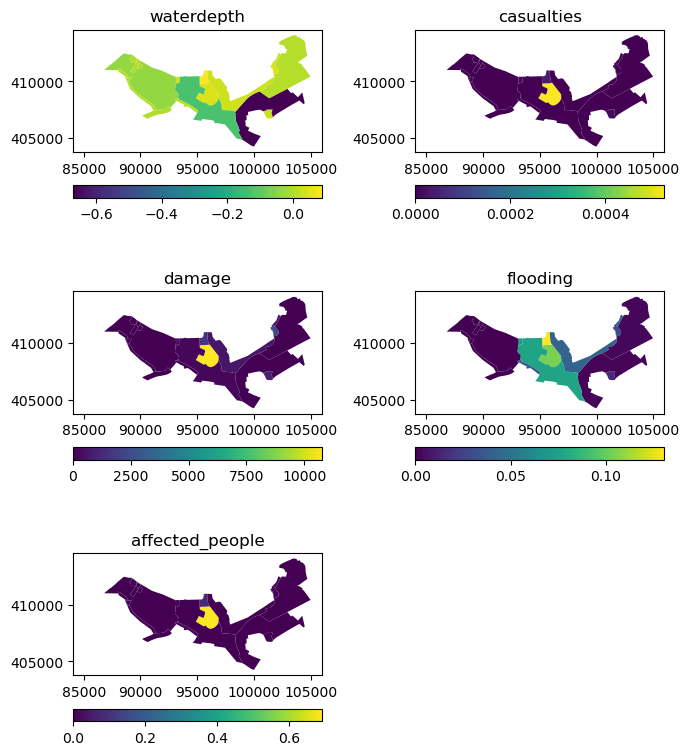

In [31]:
import matplotlib.pyplot as plt

gdf_results = calculate_flood_risk.df_out

columns = ["waterdepth", "casualties", "damage", "flooding", "affected_people"]
fig, axs = plt.subplots(3, 2, figsize=(7, 8))
ax = axs.flatten()
for index, column in enumerate(columns):
    gdf_results.plot(column=column, ax=ax[index])
    plt.colorbar(ax[index].collections[0], ax=ax[index], orientation="horizontal")
    ax[index].set_title(column)
ax[-1].axis("off")
plt.tight_layout()